# SF Crime Dataset

The San Francisco government releases crime data publically on their [website](https://na01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdata.sfgov.org%2FPublic-Safety%2FPolice-Department-Incident-Reports-Historical-2003%2Ftmnf-yvry&data=02%7C01%7Canj29%40psu.edu%7C3845569ec38a4e99dfb008d68a4efc84%7C7cf48d453ddb4389a9c1c115526eb52e%7C0%7C0%7C636848469187033158&sdata=0tibBL%2F90TsVmuAlHcBnG1uMNijGB85zmC19ezAjVqA%3D&reserved=0) 

This notebook analyses the crime dataset and gives insight about:

* Most dangerous area of SF using heatmap.
* Top 3 crimes per Police Department District
* Trend of crimes through a day
* Most type of crimes through the week
* Types of Resolution of crimes
* Classification of model using ensembling technique: RandomForestClassifier
* Hyperparameter Tuning using GridSearchCV

In [9]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Configure notebook for loading Google Maps

In [1]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
!jupyter nbextension enable --py --sys-prefix gmaps

Enabling notebook extension jupyter-gmaps/extension...
      - Validating: OK


In [4]:
import gmaps

In [11]:
import gmaps.datasets
api_key=""           # Insert Your Google API key
gmaps.configure(api_key=api_key) 

In [7]:
!jupyter nbextension enable --py gmaps

Enabling notebook extension jupyter-gmaps/extension...
      - Validating: OK


In [1]:
import pandas as pd

In [4]:
%%time
sf_crime_Data = pd.read_csv("./Data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")

CPU times: user 5.74 s, sys: 558 ms, total: 6.3 s
Wall time: 6.5 s


In [5]:
sf_crime_Data['TS'] = sf_crime_Data.Date+" "+sf_crime_Data.Time

In [6]:
sf_crime_Data.TS = pd.to_datetime(sf_crime_Data.TS, format="%m/%d/%Y %H:%M")

In [11]:
sf_crime_Data.set_index('TS',inplace=True,drop=True)

In [21]:
sf_crime_Data.sort_index(inplace=True)

**Taking excerpt of data from 1st Jan 2017**

In [25]:
data_extract_Df = sf_crime_Data.loc['2017-01-01':]
data_extract_Df.index.max(),data_extract_Df.index.min()

(Timestamp('2018-05-15 10:30:00'), Timestamp('2017-01-01 00:01:00'))

In [32]:
data_extract_Df.to_csv('./Data/data_extract.csv')

In [26]:
len(data_extract_Df)

201441

In [33]:
len(data_extract_Df.Resolution.unique())

15

In [27]:
data_extract_Df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
TS,,,,,,,,,,,,,
2017-01-01 00:01:00,170583332,OTHER OFFENSES,FALSE PERSONATION,Sunday,01/01/2017,00:01,BAYVIEW,NONE,1100 Block of WISCONSIN ST,-122.398473,37.753148,"(37.75314834602312, -122.3984731227604)",17058333209027
2017-01-01 00:01:00,176008376,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Sunday,01/01/2017,00:01,TARAVAL,NONE,1200 Block of OCEAN AV,-122.455616,37.723859,"(37.72385901200105, -122.45561586153802)",17600837606372
2017-01-01 00:01:00,170152078,NON-CRIMINAL,LOST PROPERTY,Sunday,01/01/2017,00:01,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.76505012146682, -122.41967178029562)",17015207871000
2017-01-01 00:01:00,170730862,NON-CRIMINAL,LOST PROPERTY,Sunday,01/01/2017,00:01,TARAVAL,NONE,4600 Block of LINCOLN WY,-122.507802,37.764007,"(37.76400685085615, -122.5078015077359)",17073086271000
2017-01-01 00:01:00,171033817,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Sunday,01/01/2017,00:01,TENDERLOIN,NONE,100 Block of GOLDEN GATE AV,-122.413070,37.782020,"(37.78202042558663, -122.4130699263972)",17103381764070


In [4]:
sf_crime_Data.columns

Index([u'IncidntNum', u'Category', u'Descript', u'DayOfWeek', u'Date', u'Time',
       u'PdDistrict', u'Resolution', u'Address', u'X', u'Y', u'Location',
       u'PdId'],
      dtype='object')

In [17]:
sf_crime_Data.Location[:2]

0     (37.7617007179518, -122.42158168137)
1    (37.7841907151119, -122.414406029855)
Name: Location, dtype: object

In [18]:
sf_crime_Data.X[:2],sf_crime_Data.Y[:2]

(0   -122.421582
 1   -122.414406
 Name: X, dtype: float64, 0    37.761701
 1    37.784191
 Name: Y, dtype: float64)

In [26]:
sf_locations = zip(sf_crime_Data.Y,sf_crime_Data.X)

In [27]:
sf_locations[:10]

[(37.761700717951797, -122.42158168136999),
 (37.784190715111897, -122.414406029855),
 (37.784190715111897, -122.414406029855),
 (37.784190715111897, -122.414406029855),
 (37.800468704287503, -122.43111854378799),
 (37.7870853907529, -122.451781767894),
 (37.729203356539003, -122.374019331833),
 (37.729203356539003, -122.374019331833),
 (37.787809295956102, -122.40656817786999),
 (37.786257854586502, -122.417295322526)]

### generate random sample of 2000 crimes in SF for HeatMap

In [25]:
import numpy as np

In [68]:
index=np.random.randint(len(np_loc),size=2000)

In [69]:
len(index)

2000

In [71]:
sf_sample_crimes = np_loc[index]

In [72]:
sf_sample_crimes.shape

(2000, 2)

In [73]:
sf_sample_locations =list(map(tuple, sf_sample_crimes))

In [74]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(sf_sample_locations))

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sf_crime_Data.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160


In [83]:
sf_crime_Data.isnull().values.sum()

1

In [85]:
sf_crime_Data.dropna(axis=0,inplace=True)

In [7]:
sf_crime_Data.Category.unique(),len(sf_crime_Data.Category.unique())

(array(['NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'SECONDARY CODES',
        'VANDALISM', 'BURGLARY', 'LARCENY/THEFT', 'DRUG/NARCOTIC',
        'WARRANTS', 'VEHICLE THEFT', 'OTHER OFFENSES', 'WEAPON LAWS',
        'ARSON', 'MISSING PERSON', 'DRIVING UNDER THE INFLUENCE',
        'SUSPICIOUS OCC', 'RECOVERED VEHICLE', 'DRUNKENNESS', 'TRESPASS',
        'FRAUD', 'DISORDERLY CONDUCT', 'SEX OFFENSES, FORCIBLE',
        'FORGERY/COUNTERFEITING', 'KIDNAPPING', 'EMBEZZLEMENT',
        'STOLEN PROPERTY', 'LIQUOR LAWS', 'FAMILY OFFENSES', 'LOITERING',
        'BAD CHECKS', 'TREA', 'GAMBLING', 'RUNAWAY', 'BRIBERY',
        'PROSTITUTION', 'PORNOGRAPHY/OBSCENE MAT',
        'SEX OFFENSES, NON FORCIBLE', 'SUICIDE', 'EXTORTION'], dtype=object),
 39)

**39 categories of Crime reported**

In [3]:
sf_crime_Data.Date = pd.to_datetime(sf_crime_Data.Date, format="%m/%d/%Y")

In [4]:
sf_crime_Data.Time = pd.to_datetime(sf_crime_Data.Time,format='%H:%M')

In [6]:
str(sf_crime_Data.Date[1]) + " " + str(sf_crime_Data.Time[1])

'2015-02-01 00:00:00 1900-01-01 15:45:00'

In [32]:
pd_categ_df = sf_crime_Data.groupby(['PdDistrict','Category']).size()

In [39]:
pd_categ_df = sf_crime_Data.groupby(['PdDistrict','Category']).size().reset_index(name='Number_of_Crimes')

In [46]:
pd_categ_df.columns

Index([u'PdDistrict', u'Category', u'Number_of_Crimes'], dtype='object')

In [51]:
sorted_pd_catg_df = pd_categ_df.sort_values(['PdDistrict', 'Number_of_Crimes'],ascending=False).groupby('PdDistrict').head(3)

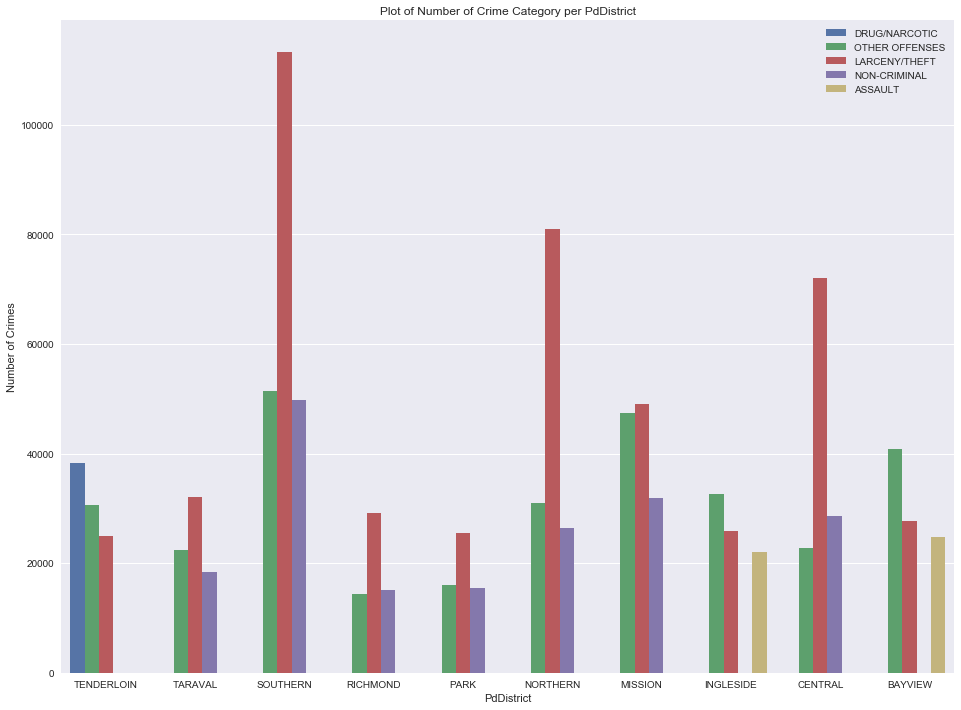

In [71]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16,12))
sns.barplot(x='PdDistrict', y='Number_of_Crimes', hue='Category', data=sorted_pd_catg_df, saturation=0.8,ax=ax)
plt.ylabel('Number of Crimes')
plt.legend(loc='upper right')
plt.title('Plot of Number of Crime Category per PdDistrict')
plt.show()


**Insight**: This plot indicates the top 3 crimes per Police Department District. It is evident from the plots that LARCENY/THEFT is the most committed crime and has happened maximum in the Southern district.

In [104]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
crime_per_hour = sf_crime_Data.groupby(sf_crime_Data.Time.dt.hour).size().reset_index(name='Count_of_Crimes')

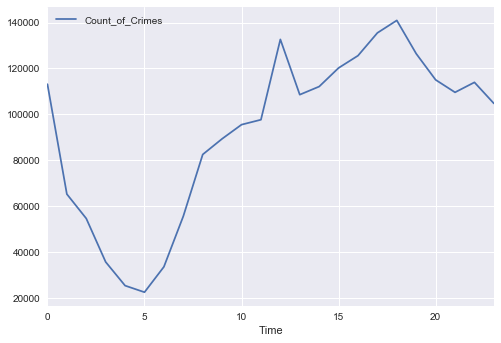

In [110]:
crime_per_hour.plot(x='Time',y='Count_of_Crimes')

**This plot gives us the insight that there is hike in number of crimes during 11AM to 2PM and increases to a maximum at around 5PM.**

In [111]:
sf_crime_Data.columns

Index([u'IncidntNum', u'Category', u'Descript', u'DayOfWeek', u'Date', u'Time',
       u'PdDistrict', u'Resolution', u'Address', u'X', u'Y', u'Location',
       u'PdId'],
      dtype='object')

In [113]:
sf_crime_Data.DayOfWeek.unique()

array(['Monday', 'Sunday', 'Tuesday', 'Saturday', 'Friday', 'Wednesday',
       'Thursday'], dtype=object)

In [118]:
pd_catg_daily_df = sf_crime_Data.groupby(['DayOfWeek','Category']).size().reset_index(name='Count_of_crimes')

In [121]:
sorted_pd_catg_daily_df = pd_catg_daily_df.sort_values(['DayOfWeek', 'Count_of_crimes'],ascending=False).groupby('DayOfWeek').head(3)

In [125]:
sorted_pd_catg_daily_df['DayOfWeek'] = pd.Categorical(sorted_pd_catg_daily_df['DayOfWeek'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)


In [126]:
sorted_pd_catg_daily_df.DayOfWeek.unique()

[Wednesday, Tuesday, Thursday, Sunday, Saturday, Monday, Friday]
Categories (7, object): [Monday < Tuesday < Wednesday < Thursday < Friday < Saturday < Sunday]

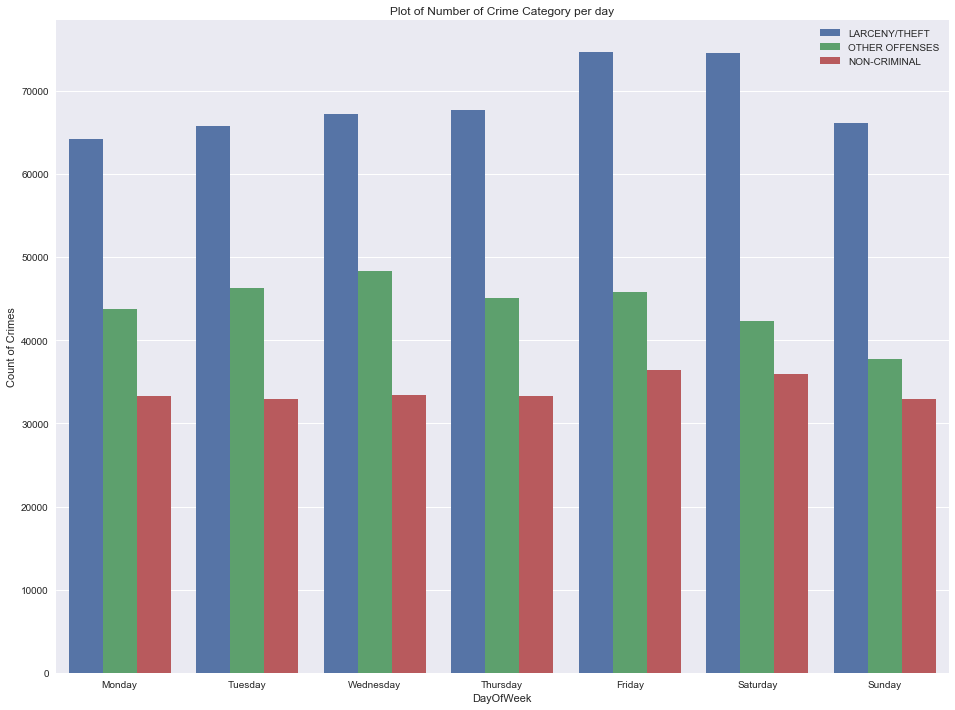

In [127]:
fig, ax = plt.subplots(figsize=(16,12))
sns.barplot(x='DayOfWeek', y='Count_of_crimes', hue='Category', data=sorted_pd_catg_daily_df, saturation=0.8,ax=ax)
plt.ylabel('Count of Crimes')
plt.legend(loc='upper right')
plt.title('Plot of Number of Crime Category per day')
plt.show()


**Insight:** The maximum number of thefts was committed on weekends, Friday and Saturday.

In [25]:
data_extract_Df = sf_crime_Data.loc['2017-01-01':]
data_extract_Df.index.max(),data_extract_Df.index.min()

(Timestamp('2018-05-15 10:30:00'), Timestamp('2017-01-01 00:01:00'))

In [32]:
data_extract_Df.to_csv('./Data/data_extract.csv')

In [26]:
len(data_extract_Df)

201441

In [33]:
len(data_extract_Df.Resolution.unique())

15

In [27]:
data_extract_Df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
TS,,,,,,,,,,,,,
2017-01-01 00:01:00,170583332,OTHER OFFENSES,FALSE PERSONATION,Sunday,01/01/2017,00:01,BAYVIEW,NONE,1100 Block of WISCONSIN ST,-122.398473,37.753148,"(37.75314834602312, -122.3984731227604)",17058333209027
2017-01-01 00:01:00,176008376,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Sunday,01/01/2017,00:01,TARAVAL,NONE,1200 Block of OCEAN AV,-122.455616,37.723859,"(37.72385901200105, -122.45561586153802)",17600837606372
2017-01-01 00:01:00,170152078,NON-CRIMINAL,LOST PROPERTY,Sunday,01/01/2017,00:01,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.76505012146682, -122.41967178029562)",17015207871000
2017-01-01 00:01:00,170730862,NON-CRIMINAL,LOST PROPERTY,Sunday,01/01/2017,00:01,TARAVAL,NONE,4600 Block of LINCOLN WY,-122.507802,37.764007,"(37.76400685085615, -122.5078015077359)",17073086271000
2017-01-01 00:01:00,171033817,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Sunday,01/01/2017,00:01,TENDERLOIN,NONE,100 Block of GOLDEN GATE AV,-122.413070,37.782020,"(37.78202042558663, -122.4130699263972)",17103381764070


**Since the full dataset consists of ~2 mil records, we narrow down to an extract from 1st Jan, 2017 to 15th May, 2018 consisting of 201441 records.**

## Modelling on extract of data

In [2]:
data_extract_Df = pd.read_csv('./Data/data_extract.csv')

In [3]:
data_extract_Df.TS = pd.to_datetime(data_extract_Df.TS, format="%Y-%m-%d %H:%M:%S")

In [4]:
data_extract_Df.Date = pd.to_datetime(data_extract_Df.Date, format="%m/%d/%Y")
data_extract_Df.Time = pd.to_datetime(data_extract_Df.Time,format='%H:%M')

In [5]:
data_extract_Df.columns

Index([u'TS', u'IncidntNum', u'Category', u'Descript', u'DayOfWeek', u'Date',
       u'Time', u'PdDistrict', u'Resolution', u'Address', u'X', u'Y',
       u'Location', u'PdId'],
      dtype='object')

In [6]:
list_of_selected_cols = ['Category','DayOfWeek','PdDistrict','Resolution','X','Y']
train_data = data_extract_Df[list_of_selected_cols]

In [7]:
train_data.columns

Index([u'Category', u'DayOfWeek', u'PdDistrict', u'Resolution', u'X', u'Y'], dtype='object')

In [8]:
train_data.head()

,Category,DayOfWeek,PdDistrict,Resolution,X,Y
0,OTHER OFFENSES,Sunday,BAYVIEW,NONE,-122.398473,37.753148
1,LARCENY/THEFT,Sunday,TARAVAL,NONE,-122.455616,37.723859
2,NON-CRIMINAL,Sunday,MISSION,NONE,-122.419672,37.765050
3,NON-CRIMINAL,Sunday,TARAVAL,NONE,-122.507802,37.764007
4,SUSPICIOUS OCC,Sunday,TENDERLOIN,NONE,-122.413070,37.782020


In [10]:
train_data['DayOfWeek'] = pd.Categorical(train_data['DayOfWeek'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)

In [11]:
train_data['Category']=train_data['Category'].astype('category')
train_data['PdDistrict']=train_data['PdDistrict'].astype('category')
train_data['Resolution']=train_data['Resolution'].astype('category')

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201441 entries, 0 to 201440
Data columns (total 6 columns):
Category      201441 non-null category
DayOfWeek     201441 non-null category
PdDistrict    201441 non-null category
Resolution    201441 non-null category
X             201441 non-null float64
Y             201441 non-null float64
dtypes: category(4), float64(2)
memory usage: 3.8 MB


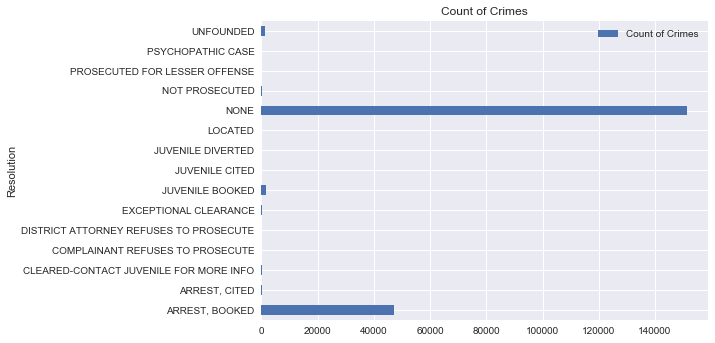

In [16]:
train_data.groupby('Resolution').size().reset_index(name='Count of Crimes').plot.barh(x='Resolution')
plt.title("Count of Crimes")
plt.show()

This shows that the dataset is heavily imbalanced with **None** being the most highest in Resolution biasing the dataset.

## Data Preparation

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
labels = train_data.Resolution.values
le = LabelEncoder()
le.fit(labels)
transformed_labels = le.transform(labels)

**Converting Categorical features to one-hot encoded format**

In [15]:
transf_train_data = pd.get_dummies(train_data.loc[:,train_data.columns!='Resolution'])

In [16]:
transf_train_data.head()

,X,Y,Category_ARSON,Category_ASSAULT,Category_BAD CHECKS,Category_BRIBERY,Category_BURGLARY,Category_DISORDERLY CONDUCT,Category_DRIVING UNDER THE INFLUENCE,Category_DRUG/NARCOTIC,...,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
0,-122.398473,37.753148,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-122.455616,37.723859,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-122.419672,37.765050,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,-122.507802,37.764007,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-122.413070,37.782020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [45]:
transf_train_data.shape

(201441, 58)

In [50]:
transformed_labels.shape

(201441,)

In [115]:
train_data.shape

(201441, 6)

**Train_Test split ratio: 80:20 with 1st 80% of data for the training of model and rest for testing**

In [17]:
train_partition_index = int(0.8*transf_train_data.shape[0])

train_x, train_y = transf_train_data.iloc[:train_partition_index,:], transformed_labels[:train_partition_index]
test_x, test_y = transf_train_data.iloc[train_partition_index:,:], transformed_labels[train_partition_index:]


In [18]:
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((161152, 58), (40289, 58), (161152,), (40289,))

## Modelling using Random Forest Classifier

Random Forest is a *bagging* technique which uses trees of weak classifiers to collectively find a strong classifier and as an enhancement to the normal bagging technique, it randomly selects set of features of the dataset to build classifiers or 'trees'. 

Since the dataset has high variance, Random Forest was one of the most suitable techniques for classification.

In [19]:
train_x.head()

,X,Y,Category_ARSON,Category_ASSAULT,Category_BAD CHECKS,Category_BRIBERY,Category_BURGLARY,Category_DISORDERLY CONDUCT,Category_DRIVING UNDER THE INFLUENCE,Category_DRUG/NARCOTIC,...,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
0,-122.398473,37.753148,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,-122.455616,37.723859,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-122.419672,37.765050,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,-122.507802,37.764007,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-122.413070,37.782020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
from sklearn.metrics import recall_score,precision_score,confusion_matrix,accuracy_score,cohen_kappa_score
import numpy as np

In [22]:
class_names = le.inverse_transform(test_y)

**It had been shown in the above dataset that Resolution category is highly imbalanced. Thus, 'balanced_subsample' is passed to class_weight to take care of the imbalance to avoid upsampling/downsampling** [[Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)]

In [25]:
clf_1=RandomForestClassifier(n_estimators=100,max_depth=10,class_weight="balanced_subsample")

clf_1.fit(train_x,train_y)

# prediction on test set
pred_y = clf_1.predict(test_x)

print "Accuracy:\t",accuracy_score(test_y, pred_y)


precision = precision_score(test_y, pred_y, average='weighted')  
print "Precision:\t",precision

recall = recall_score(test_y, pred_y, average='weighted')  
print "Recall:\t",recall


Accuracy:	0.566904117749
Precision:	0.835426998201
Recall:	0.566904117749


In [28]:
kappa_score = cohen_kappa_score(test_y, pred_y)
print "Kappa_score:\t",kappa_score

Kappa_score:	0.293918265095


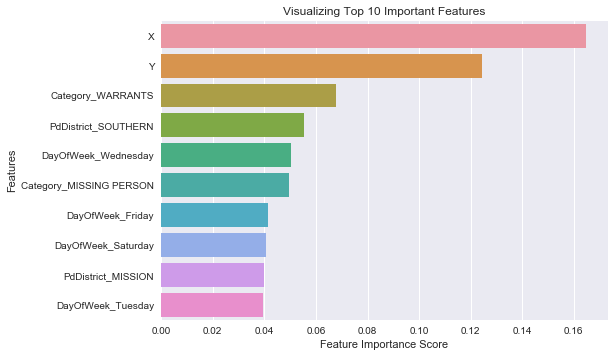

In [31]:
feature_imp = pd.Series(clf_1.feature_importances_,index=train_x.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Top 10 Important Features")
plt.legend()
plt.show()

**This tells us that the features X and Y, precisely the location of the crime is major decider for the final classification of the crime**

## GridsearchCV for parameter tuning

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

clf_2=RandomForestClassifier(n_estimators=100,class_weight="balanced_subsample")

param_grid = {"max_depth": [5, 10, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf_2, param_grid=param_grid, cv=5)
grid_search.fit(train_x,train_y)

/Users/achyutajha/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [70]:
pred_y = grid_search.predict(test_x)

**Building same model as GridSearchCV's best model configuration**

In [32]:
clf_grid = RandomForestClassifier(n_estimators=100,class_weight='balanced_subsample',max_depth= None,\
                                  max_features =10, min_samples_split = 10,\
                                  bootstrap  = True, criterion='entropy')

In [34]:
clf_grid.fit(train_x,train_y)

# prediction on test set
pred_y = clf_grid.predict(test_x)

print "Accuracy: ",accuracy_score(test_y, pred_y)


precision = precision_score(test_y, pred_y, average='weighted')  
print "Precision: ",precision

recall = recall_score(test_y, pred_y, average='weighted')  
print "Recall: ",recall

Accuracy:  0.784035344635
Precision:  0.805934000327
Recall:  0.784035344635


In [110]:
kappa_score = metrics.cohen_kappa_score(test_y, pred_y)
kappa_score

0.46211496750876957

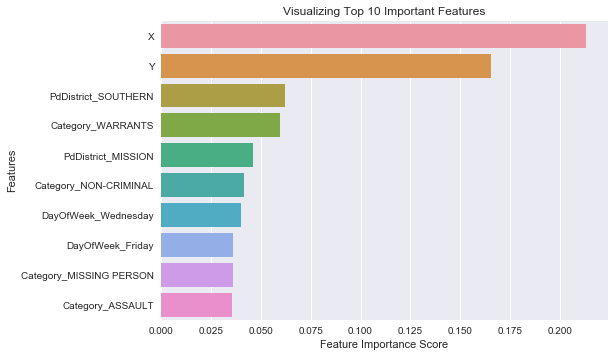

In [116]:
feature_imp = pd.Series(clf_grid.feature_importances_,index=train_x.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Top 10 Important Features")
plt.legend()
plt.show()

## Conclusion

In the end the metrics for classification improved by the Hyperparameter Tuning. 'SMOTE' for oversampling or 'NearMiss' for undersampling can also be used to take care of the imbalanced dataset. 
Thus, with this analysis, the Police Department can prioritize the crimes depending on historic trend of the data.